In [12]:
import pandas as pd
from ultralytics import YOLO

In [13]:
img_index = pd.read_csv('image_index.csv')
img_index

,path,date_folder,timestamp,location,image_id
0,../image_downloader/images/2025-04-20/17451432...,2025-04-20,1745143200,MC_DHPOS,1745143200_MC_DHPOS
1,../image_downloader/images/2025-04-20/17451432...,2025-04-20,1745143200,MC_DHService1,1745143200_MC_DHService1
2,../image_downloader/images/2025-04-20/17451432...,2025-04-20,1745143200,MC_DHService2,1745143200_MC_DHService2
3,../image_downloader/images/2025-04-20/17451432...,2025-04-20,1745143200,MC_DHSmoothies,1745143200_MC_DHSmoothies
4,../image_downloader/images/2025-04-20/17451432...,2025-04-20,1745143200,MC_Exit1,1745143200_MC_Exit1
...,...,...,...,...,...
1689291,../image_downloader/images/2025-03-20/17425203...,2025-03-20,1742520304,MC_DHService2,1742520304_MC_DHService2
1689292,../image_downloader/images/2025-03-20/17424744...,2025-03-20,1742474469,NH_DHPOS2,1742474469_NH_DHPOS2
1689293,../image_downloader/images/2025-03-20/17424943...,2025-03-20,1742494378,MC_Exit1,1742494378_MC_Exit1
1689294,../image_downloader/images/2025-03-20/17424816...,2025-03-20,1742481647,MC_PO,1742481647_MC_PO


In [20]:
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 303MB/s]


In [19]:
start_date = '2025-03-17'
end_date = '2025-04-13'

q = (start_date <= img_index['date_folder']) & (img_index['date_folder'] <= end_date)

img_index = img_index[q]
img_index

,path,date_folder,timestamp,location,image_id
207179,../image_downloader/images/2025-03-19/17423900...,2025-03-19,1742390088,NH_DHDeli,1742390088_NH_DHDeli
207180,../image_downloader/images/2025-03-19/17423895...,2025-03-19,1742389519,MC_Exit2,1742389519_MC_Exit2
207181,../image_downloader/images/2025-03-19/17423846...,2025-03-19,1742384680,MC_PO,1742384680_MC_PO
207182,../image_downloader/images/2025-03-19/17423808...,2025-03-19,1742380850,MC_DHService1,1742380850_MC_DHService1
207183,../image_downloader/images/2025-03-19/17424226...,2025-03-19,1742422697,NH_DHGym,1742422697_NH_DHGym
...,...,...,...,...,...
1689291,../image_downloader/images/2025-03-20/17425203...,2025-03-20,1742520304,MC_DHService2,1742520304_MC_DHService2
1689292,../image_downloader/images/2025-03-20/17424744...,2025-03-20,1742474469,NH_DHPOS2,1742474469_NH_DHPOS2
1689293,../image_downloader/images/2025-03-20/17424943...,2025-03-20,1742494378,MC_Exit1,1742494378_MC_Exit1
1689294,../image_downloader/images/2025-03-20/17424816...,2025-03-20,1742481647,MC_PO,1742481647_MC_PO


In [4]:
res = model(img_index['path'][100_000])


image 1/1 /teamspace/studios/this_studio/athena-full-circle/analysis/../image_downloader/images/2025-04-22/1745367448_MC_DHSmoothies.jpg: 480x640 2 persons, 1 handbag, 11 bottles, 53.4ms
Speed: 5.3ms preprocess, 53.4ms inference, 1005.9ms postprocess per image at shape (1, 3, 480, 640)


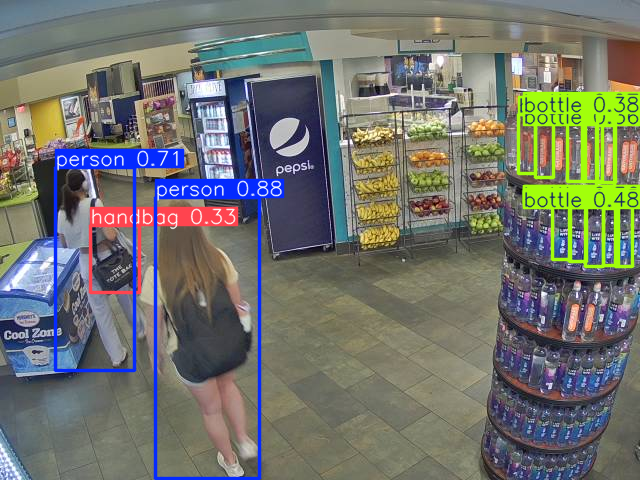

In [11]:
res[0].show()

In [21]:
from PIL import Image
from tqdm import tqdm

valid_paths = []
valid_ids = []

for path, image_id in tqdm(zip(img_index['path'], img_index['image_id'])):
    try:
        with Image.open(path) as img:
            img.verify()  # Verify image integrity
        valid_paths.append(path)
        valid_ids.append(image_id)
    except Exception:
        continue  # Skip corrupted or unreadable images

964756it [09:52, 1626.96it/s]


In [6]:
import pandas as pd
from tqdm import tqdm

chunk_size = 256
all_results = []

paths = valid_paths
image_ids = valid_ids

for i in tqdm(range((len(img_index) + chunk_size - 1) // chunk_size)):
    batch = paths[i*chunk_size:(i+1)*chunk_size]
    batch_ids = image_ids[i*chunk_size:(i+1)*chunk_size]
    
    results = model(batch, imgsz=(480, 640), half=True, classes=[0], verbose=False)
    all_results.extend(zip(batch_ids, results))


  6%|▌         | 46/810 [02:00<33:18,  2.62s/it] 


KeyboardInterrupt: 

In [ ]:
all_preds = []
for image_id, pred in zip(batch_ids, results):
    boxes = pred.boxes
    if boxes is not None:
        for box, conf in zip(boxes.xyxy.cpu().numpy(), boxes.conf.cpu().numpy()):
            x1, y1, x2, y2 = box
            all_preds.append({
                'image_id': image_id,
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'confidence': conf
            })

preds_df = pd.DataFrame(all_preds)
preds_df.to_parquet("predictions.parquet", index=False)

In [ ]:
import pandas as pd
from tqdm import tqdm

chunk_size = 256
save_interval = 20  # Save every 20 chunks
all_preds = []

paths = valid_paths
image_ids = valid_ids

# Keep track of output file count
save_count = 0

for i in tqdm(range((len(paths) + chunk_size - 1) // chunk_size)):
    batch = paths[i*chunk_size:(i+1)*chunk_size]
    batch_ids = image_ids[i*chunk_size:(i+1)*chunk_size]
    
    try:
        results = model(batch, imgsz=(480, 640), half=True, classes=[0], verbose=False)
    except Exception as e:
        print(f"Error processing chunk {i}: {e}")
        continue

    chunk_preds = []
    for image_id, pred in zip(batch_ids, results):
        boxes = pred.boxes
        if boxes is not None:
            for box, conf in zip(boxes.xyxy.cpu().numpy(), boxes.conf.cpu().numpy()):
                x1, y1, x2, y2 = box
                chunk_preds.append((image_id, x1, y1, x2, y2, conf))
    
    # Save periodically to Parquet to avoid large memory usage
    if chunk_preds:
        df = pd.DataFrame(chunk_preds, columns=["image_id", "x1", "y1", "x2", "y2", "confidence"])
        df.to_parquet(f"predictions_chunk_{save_count:03d}.parquet", index=False)
        save_count += 1


In [8]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 196.8 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import os

# Define parameters
chunk_size = 512
save_frequency = 50
paths = valid_paths
image_ids = valid_ids
output_path = "predictions.parquet"

# Define schema
schema = pa.schema([
    ('image_id', pa.string()),
    ('x1', pa.float32()),
    ('y1', pa.float32()),
    ('x2', pa.float32()),
    ('y2', pa.float32()),
    ('confidence', pa.float32())
])

# Initialize storage for collecting batches
all_image_ids, all_x1, all_y1, all_x2, all_y2, all_conf = [], [], [], [], [], []

# Initialize the writer once at the beginning
writer = pq.ParquetWriter(output_path, schema)

# Process batches
for i in tqdm(range((len(img_index) + chunk_size - 1) // chunk_size)):
    batch = paths[i*chunk_size:(i+1)*chunk_size]
    batch_ids = image_ids[i*chunk_size:(i+1)*chunk_size]
    
    # Run inference
    results = model(batch, imgsz=(480, 640), half=True, classes=[0], verbose=False)
    
    # Process results directly to arrays
    for image_id, pred in zip(batch_ids, results):
        boxes = pred.boxes
        if boxes is not None and len(boxes.xyxy) > 0:
            xyxy = boxes.xyxy.cpu().numpy()
            confs = boxes.conf.cpu().numpy()
            box_count = len(xyxy)
            
            all_image_ids.extend([image_id] * box_count)
            all_x1.extend(xyxy[:, 0])
            all_y1.extend(xyxy[:, 1])
            all_x2.extend(xyxy[:, 2])
            all_y2.extend(xyxy[:, 3])
            all_conf.extend(confs)
    
    # Save results when we reach save_frequency or at the end
    if (i + 1) % save_frequency == 0 or (i + 1) == ((len(img_index) + chunk_size - 1) // chunk_size):
        if all_image_ids:  # Only create a table if we have data
            # Create batch table from all collected data
            batch_table = pa.Table.from_arrays(
                [
                    pa.array(all_image_ids),
                    pa.array(all_x1, type=pa.float32()),
                    pa.array(all_y1, type=pa.float32()),
                    pa.array(all_x2, type=pa.float32()),
                    pa.array(all_y2, type=pa.float32()),
                    pa.array(all_conf, type=pa.float32())
                ],
                schema=schema
            )
            
            # Write the batch
            writer.write_table(batch_table)
                
            # Clear arrays after saving
            all_image_ids, all_x1, all_y1, all_x2, all_y2, all_conf = [], [], [], [], [], []

# Close the writer when done
writer.close()

print(f"Processing complete. Results saved to {output_path}")

100%|██████████| 1885/1885 [2:51:53<00:00,  5.47s/it]  

Processing complete. Results saved to predictions.parquet
